# UCI adult data set

In [1]:
%matplotlib inline

import pandas as pd
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

In [2]:
pd.__version__

'0.23.1'

## Preprocess UCI adult data

This requires downloading the UCI data [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/).

In [3]:
# Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

In [4]:
# Redundant column
del original["Education"]

# Remove target variable
del original["Target"]

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

data = data_transform(original)
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

## Logistic regression model

In [5]:
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Marginal table

Let's create a marginal table of the attributes we're interested in: target, score, prediction, race, gender.

In [6]:
predictions = cls.predict(test_data)
scores = cls.predict_proba(test_data)[:, 1]

d = {'target' : test_labels.as_matrix(),
     'score' : scores,
     'prediction' : predictions,
     'race' : original_test['Race'],
     'gender' : original_test['Sex']}

marginals = pd.DataFrame(data=d, columns=['target', 'score', 'prediction', 'race', 'gender'])
marginals.head()

/home/mrtz/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


,target,score,prediction,race,gender
0,0,0.002771,0,Black,Male
1,0,0.117784,0,White,Male
2,1,0.456686,0,White,Male
3,1,0.754575,1,Black,Male
4,0,0.001230,0,White,Female


### Calibration values

In [7]:
def score_range(p, q, df):
    """Returns number of success and observations for given bucket."""
    gp = df[df['score'] > p]
    lq = gp[gp['score'] <= q]
    return [sum(lq['target']), len(lq['target'])]

def get_frequencies(marginals, num_buckets=10):
    """Returns list of lists. The first list is successes 
    for all buckets, the second one is total counts."""
    ts = np.linspace(0, 1, num_buckets+1)
    frequencies = [[],[]]
    for i in range(num_buckets):
        b = score_range(ts[i], ts[i+1], marginals)
        frequencies[0].append(b[0])
        frequencies[1].append(b[1])
    return frequencies

def plot_confidence(plt, xs, n_succs, n_obss, label, linestyle, color, confidence=0.95):
    """Plot a graph with confidence intervals where
       each x corresponds to a binomial random variable in which n_obs observations led to n_succ successes"""
    n_succs, n_obss = np.array(n_succs), np.array(n_obss)
    conf_lbs, conf_ubs = proportion.proportion_confint(n_succs, n_obss, alpha=1-confidence)
    pylab.fill_between(xs, conf_ubs, conf_lbs, alpha=.2, color=color)
    pylab.plot(xs, n_succs / n_obss, '.-', label=label, linestyle=linestyle, color=color)

#### By group

In [35]:
races = ['White', 'Black']
styles = ['-', '--']
colors = ['g', 'b']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

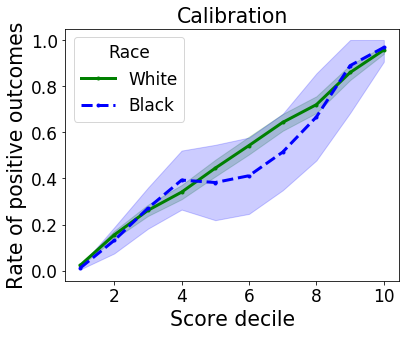

In [36]:
pylab.figure(1, figsize=(6, 5))
pylab.title('Calibration')

for i in range(2):
    race = races[i]
    num = get_frequencies(marginals[marginals['race']== race])
    plot_confidence(plt, deciles, num[0], num[1], race, styles[i], colors[i])

pylab.legend(title="Race")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')
pylab.tight_layout()
pylab.savefig('../figures/adult_calibration_race.svg')
pylab.savefig('../figures/adult_calibration_race.pdf')

#### By race

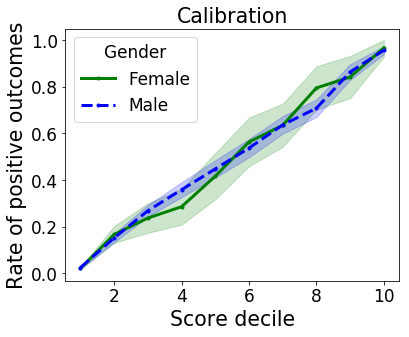

In [37]:
genders = ['Female', 'Male']
pylab.figure(2, figsize=(6, 5))
pylab.title('Calibration')

for i in range(2):
    gender = genders[i]
    num = get_frequencies(marginals[marginals['gender']== gender])
    plot_confidence(plt, deciles, num[0], num[1], gender, styles[i], colors[i])
    
plt.legend(title="Gender")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')
pylab.tight_layout()
pylab.savefig('../figures/adult_calibration_gender.svg')
pylab.savefig('../figures/adult_calibration_gender.pdf')
pylab.show()
pylab.close()

#### Sample sizes

In [10]:
(len(original_test[original_test['Race']=='Black']),
len(original_test[original_test['Race']=='White']),
len(original_test[original_test['Sex']=='Male']),
len(original_test[original_test['Sex']=='Female']))

(1561, 13946, 10860, 5421)

The deviation in the calibration plot by race in the 6th decile could be due to a lack of data in this range.

In [11]:
def testrange(p, q, df):
    """Returns individuals in dataframe with p < score <= q."""
    gp = df[df['score'] > p]
    return gp[gp['score'] <= q]

In [12]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [13]:
ts = np.linspace(0, 1, 10+1)
for i in range(10):
    df = testrange(ts[i], ts[i+1], marginals[marginals['race']=='Black'])
    print("Number of instances with race attribute set to 'Black' in", str(i)+"th decile: ", len(df))

Number of instances with race attribute set to 'Black' in 0th decile:  1105
Number of instances with race attribute set to 'Black' in 1th decile:  137
Number of instances with race attribute set to 'Black' in 2th decile:  96
Number of instances with race attribute set to 'Black' in 3th decile:  56
Number of instances with race attribute set to 'Black' in 4th decile:  34
Number of instances with race attribute set to 'Black' in 5th decile:  34
Number of instances with race attribute set to 'Black' in 6th decile:  35
Number of instances with race attribute set to 'Black' in 7th decile:  24
Number of instances with race attribute set to 'Black' in 8th decile:  9
Number of instances with race attribute set to 'Black' in 9th decile:  31


There are 1561 total instances where the race attribute is set to "Black," but the majority of those instances fall in the 0 through 2nd deciles.

### ROC curves

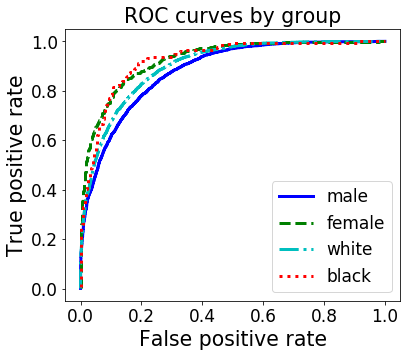

In [48]:
male = marginals[marginals['gender'] == 'Male']
fpr_male, tpr_male, _ = metrics.roc_curve(male['target'], male['score'])
female = marginals[marginals['gender'] == 'Female']
fpr_female, tpr_female, _ = metrics.roc_curve(female['target'], female['score'])
white = marginals[marginals['race'] == 'White']
fpr_white, tpr_white, _ = metrics.roc_curve(white['target'], white['score'])
black = marginals[marginals['race'] == 'Black']
fpr_black, tpr_black, _ = metrics.roc_curve(black['target'], black['score'])
plt.figure(1, figsize=(6, 5))
plt.title('ROC curves by group')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr_male, tpr_male, label='male', linestyle='-', color='b')
plt.plot(fpr_female, tpr_female, label='female', linestyle='--', color='g')
plt.plot(fpr_white, tpr_white, label='white', linestyle='-.', color='c')
plt.plot(fpr_black, tpr_black, label='black', linestyle=':', color='r')
plt.legend()
plt.show()

Interestingly enough, our logistic regression model has relatively high accuracy for the Black race group. This may be due to the lack of diversity in target values, which allows the model to achieve high accuracy rates by consistently predicting a particular label.

In [23]:
# Our original table

roc_original.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [44]:
# Possible target values

roc_original['Target'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [40]:
total_black = len(roc_original[roc_original['Race']=='Black'])
total_white = len(roc_original[roc_original['Race']=='White'])
total_male = len(roc_original[roc_original['Sex']=='Male'])
total_female = len(roc_original[roc_original['Sex']=='Female'])
black = roc_original[roc_original['Race']=='Black']
white = roc_original[roc_original['Race']=='White']
male = roc_original[roc_original['Sex']=='Male']
female = roc_original[roc_original['Sex']=='Female']

# Race

black_less50K = len(black[(black.Target == '<=50K') | (black.Target == '<=50K.')])/total_black
black_greater50K = len(black[(black.Target == '>50K') | (black.Target == '>50K.')])/total_black
white_less50K = len(white[(white.Target == '<=50K') | (white.Target == '<=50K.')])/total_white
white_greater50K = len(white[(white.Target == '>50K') | (white.Target == '>50K.')])/total_white

target_percent = pd.DataFrame({'<=50K': [black_less50K, white_less50K], '>50K': [black_greater50K, white_greater50K]}, index=['Black', 'White'])
target_percent

,<=50K,>50K
Black,0.879189,0.120811
White,0.746013,0.253987


In [42]:
# Gender

female_less50K = len(female[(female.Target == '<=50K') | (female.Target == '<=50K.')])/total_female
female_greater50K = len(female[(female.Target == '>50K') | (female.Target == '>50K.')])/total_female
male_less50K = len(male[(male.Target == '<=50K') | (male.Target == '<=50K.')])/total_male
male_greater50K = len(male[(male.Target == '>50K') | (male.Target == '>50K.')])/total_male

target_percent = pd.DataFrame({'<=50K': [female_less50K, male_less50K], '>50K': [female_greater50K, male_greater50K]}, index=['Female', 'Male'])
target_percent

,<=50K,>50K
Female,0.890749,0.109251
Male,0.696233,0.303767


In our original data, we can see that the male gender group has the most variability in income levels and the lowest accuracy of all the groups.